<a href="https://colab.research.google.com/github/jzyee/water_stress_proj/blob/master/benchtesting/segmentation2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Segmentation applied to real ndvi** 

this notebook is for checking the SPEI and comparing it against the breakpoints in benchmark

In [ ]:
! pip install --upgrade statsmodels
! pip install tslearn
! pip install pycausalimpact
! pip install ruptures

     |████████████████████████████████| 8.7MB 4.6MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


     |████████████████████████████████| 778kB 4.3MB/s 
     |████████████████████████████████| 61kB 3.0MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
% cd /content/gdrive/'My Drive'/water_stress_detection

/content/gdrive/My Drive/water_stress_detection


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from scipy import stats
from functools import partial
import numpy as np
# cpdetect has been modified to fit code
from cpdetect.cpdetect import cpDetector
import os
from causalimpact import CausalImpact
import matplotlib.colors as colors
import matplotlib.cm as cmx
#from bfast import BFASTMonitor
from random import seed
from random import gauss
import seaborn as sns
import ruptures as rpt
from ruptures.metrics import hausdorff, randindex, precision_recall

import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

from sklearn.model_selection import train_test_split

#Supress default INFO logging
import logging, sys
logging.disable(sys.maxsize)

plt.rcParams["figure.figsize"] = (18,6)

import warnings
warnings.simplefilter('ignore')

# load climate data

In [ ]:
def combine_eob(site_id):
  '''
  RR - daily sum preciptation
  PP - daily sea level pressure
  TG - daily mean temp
  TN - daily min temp
  TX - daily max temp
  
  '''
  type_list = ['pp', 'rr', 'tg', 'tn', 'tx']

  folder_path = 'data_files/monthly_means/'

  # file naming convention
  # file_cov = 'wind_monthly_'
  # file_name = 'SWIT345'

  start_name_cov = 'monthly_mean_'
  end_name_cov = '_EBTRN'

  out_df = None

  for idx, data_type in enumerate(type_list):
    file_path = folder_path + start_name_cov + data_type + end_name_cov + '.csv'
    if idx == 0:
      df = pd.read_csv(file_path, parse_dates=True).set_index(['Date'])[[site_id]]
      df = df.rename(columns={site_id: data_type})
    
    else:
      df[data_type] = pd.read_csv(file_path, parse_dates=True).set_index(['Date'])[site_id]

  
  return df

def get_climate_and_ndvi(site_id):
  harm_df = pd.read_csv('data_files/processed_harm_ndvi.csv', parse_dates=True)
  harm_df.index = pd.to_datetime(harm_df.iloc[:,0], format='%Y-%m-%d') 
  harm_df = harm_df.iloc[:,1:]
  harm_df.index.name = 'Date'
  # filter out the useable dates
  harm_df = harm_df.loc[(harm_df.index > '1986') & (harm_df.index < '2019')]
  # get the climate data
  df = combine_eob(site_id)
  df = df.loc[(df.index > '1986') & (df.index < '2019')]

  df['ndvi'] = harm_df[site_id]
  return df

def format_cols_casualimpact(df, y_col_name):
  '''
  description: formating column names to fit casual impact function

                example of format:
                data = pd.DataFrame({'x0': x0, 'x1': x1, 'y': y}, 
                                     columns=['y', 'x0', 'x1'])

  returns: dataframe with correct columns names as seen in example

  '''
  old_list = df.columns.to_list()
  new_cols = {}
  
  for idx, col in enumerate(old_list):
    if col != y_col_name:
      new_cols['x'+str(idx)] = col
    else:
      new_cols['y'] = y_col_name

  df.columns = new_cols
  
  #rearranging cols
  rearrange_cols = list([df.columns[-1]]) + list(df.columns[:-1])
  df = df[rearrange_cols]

  return(df)

all_data_df = get_climate_and_ndvi('SWIT345')
display(all_data_df)
all_formatted_data_df = format_cols_casualimpact(all_data_df, 'ndvi')
all_formatted_data_df

,pp,rr,tg,tn,tx,ndvi
Date,,,,,,
1986-01-31,1013.900015,4.864516,0.975806,-1.707742,4.251935,0.318780
1986-02-28,1011.242872,1.735714,-1.354286,-3.848571,1.692143,0.230058
1986-03-31,1017.496789,1.303226,5.091613,1.864516,9.023226,0.141337
1986-04-30,1010.876682,14.556667,6.509667,3.884333,9.810333,0.338837
1986-05-31,1017.780660,5.577419,15.047096,10.819677,20.320645,0.623102
...,...,...,...,...,...,...
2018-08-31,1015.622596,4.951613,21.207419,16.348709,27.032257,0.830514
2018-09-30,1019.583349,0.940000,17.796333,13.199000,23.126333,0.832393
2018-10-31,1017.651628,9.716129,13.152258,9.296451,17.583225,0.760072


,y,x0,x1,x2,x3,x4
Date,,,,,,
1986-01-31,0.318780,1013.900015,4.864516,0.975806,-1.707742,4.251935
1986-02-28,0.230058,1011.242872,1.735714,-1.354286,-3.848571,1.692143
1986-03-31,0.141337,1017.496789,1.303226,5.091613,1.864516,9.023226
1986-04-30,0.338837,1010.876682,14.556667,6.509667,3.884333,9.810333
1986-05-31,0.623102,1017.780660,5.577419,15.047096,10.819677,20.320645
...,...,...,...,...,...,...
2018-08-31,0.830514,1015.622596,4.951613,21.207419,16.348709,27.032257
2018-09-30,0.832393,1019.583349,0.940000,17.796333,13.199000,23.126333
2018-10-31,0.760072,1017.651628,9.716129,13.152258,9.296451,17.583225


## load harm ndvi

In [ ]:
harm_df = pd.read_csv('data_files/processed_harm_ndvi.csv', parse_dates=True)
harm_df.index = pd.to_datetime(harm_df.iloc[:,0], format='%Y-%m-%d') 
harm_df = harm_df.iloc[:,1:]
harm_df.index.name = 'Date'

#full years only
harm_df = harm_df.loc[(harm_df.index > '1986') & (harm_df.index < '2019')]

harm_df.head()

,FMMOL,E12,ELFI,BBOB,VERMTL,CAN,befa,TZEI,GERM210,FELSM,CRO,UK67,OGEW,FSGW,FOU,SWIT259,VERM11,UK99,OSDS,Kom,SERR15,WESC,TOC,BOS_PER,OeS,OR2,Sinca3,OSSA06,CRO_CUD,MBA,E17,UK62,SZBH,CLFS,Sinca6,KNJB,E07,DRFS,QPOM,Gks,...,SHTS,CRO_RAM,RIED,DOFS,MSC,LR3,M04,MWSB,E09,PENNA,CEB,E39,UK10,FPTRE2,FSSW,QGHC,GERM206,DK1014,ROM_SEB,KAMP,M27,mos,SLO_SUT,HSKM,MON1,PIOV,NGMW,PWTS,FS30,s121,BALD,Runcu2,Z1,ITAL037,AGNE,LE50,NGLS,AFO,M11,BB
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1986-01-31,0.588699,0.532026,-0.117098,0.261137,-0.106084,0.195253,0.385088,-0.053554,0.539252,0.175342,0.281760,0.129390,-0.023868,0.565244,0.536370,-0.015052,0.401894,0.328261,0.102050,0.623523,0.401523,0.662059,0.496613,0.595116,0.682529,-0.012000,0.346003,0.241364,0.792553,0.304651,0.256432,0.667815,0.461104,0.252426,0.482364,0.675806,0.400853,0.497374,0.150064,0.505505,...,0.624156,0.759213,0.509677,0.790643,0.449974,0.572477,0.414582,0.638375,0.487695,0.759517,0.544454,0.249647,0.279786,0.405226,0.318868,0.403744,0.683440,0.711980,0.780428,0.472334,0.625440,0.663763,0.255201,0.588158,0.364799,0.617671,0.089124,0.106188,0.683394,0.392504,0.601957,0.442854,0.536782,0.277185,0.770591,0.436001,0.000922,0.476973,0.702265,0.399661
1986-02-28,0.554890,0.457753,0.007323,0.321345,0.015089,0.258110,0.379697,-0.063945,0.483418,0.223198,0.313686,0.113259,0.069031,0.562188,0.565291,0.151749,0.388719,0.138581,0.007619,0.600863,0.382496,0.659720,0.404516,0.583059,0.676510,-0.036839,0.336819,0.337653,0.796227,0.316285,0.173154,0.689458,0.394655,0.217054,0.472183,0.643122,0.399247,0.431509,0.012488,0.481699,...,0.627678,0.758698,0.522640,0.794796,0.408326,0.624847,0.424374,0.612923,0.432580,0.776336,0.503469,0.239058,0.296808,0.440045,0.379310,0.363100,0.672214,0.713632,0.781307,0.441170,0.664792,0.674327,0.006935,0.558765,0.316708,0.610609,-0.045802,0.102431,0.717420,0.309421,0.612397,0.456885,0.505272,0.305149,0.774930,0.503290,-0.123177,0.192814,0.728536,0.336341
1986-03-31,0.521082,0.383480,0.137212,0.381553,0.136262,0.320967,0.374306,0.190980,0.369832,0.271054,0.345612,0.097127,0.189324,0.559132,0.594211,0.318550,0.375544,0.276540,0.179150,0.578203,0.363469,0.657381,0.312419,0.571002,0.670491,-0.061677,0.327635,0.433942,0.799901,0.327920,0.384636,0.711101,0.328205,0.181681,0.462002,0.610438,0.397641,0.365643,0.161717,0.457892,...,0.631201,0.758183,0.535603,0.798949,0.366679,0.677217,0.434167,0.587471,0.377465,0.793155,0.462483,0.228470,0.373729,0.474864,0.491146,0.322456,0.660987,0.715284,0.782187,0.410006,0.704144,0.684891,0.172465,0.529373,0.446663,0.603547,0.108988,0.098675,0.751445,0.226337,0.622837,0.470915,0.473762,0.333112,0.779268,0.570578,-0.093596,0.296651,0.754806,0.273021
1986-04-30,0.611562,0.457194,0.347790,0.441762,0.257435,0.383823,0.618736,0.351527,0.256246,0.318911,0.377537,0.080996,0.309618,0.556076,0.623131,0.485351,0.362369,0.414498,0.350682,0.467087,0.344442,0.655042,0.427420,0.655196,0.664472,0.028713,0.318450,0.530231,0.803574,0.339554,0.596118,0.732744,0.460783,0.146309,0.451820,0.577754,0.396035,0.299778,0.310945,0.434086,...,0.634724,0.757668,0.548566,0.803102,0.508223,0.729587,0.443959,0.562019,0.465331,0.809975,0.421498,0.440522,0.450651,0.509684,0.602981,0.502128,0.649760,0.716936,0.783066,0.378842,0.743496,0.695455,0.337995,0.499981,0.576618,0.596485,0.263777,0.115137,0.785471,0.357857,0.633277,0.484946,0.442252,0.505279,0.783607,0.637867,0.073822,0.400489,0.781077,0.375902
1986-05-31,0.754400,0.530909,0.558369,0.501970,0.378609,0.446680,0.863166,0.512075,0.728913,0.366767,0.704559,0.064864,0.429911,0.553019,0.670218,0.652151,0.762470,0.552457,0.522213,0.711666,0.569144,0.652703,0.542421,0.739389,0.658453,0.119103,0.694756,0.769430,0.807248,0.515376,0.807600,0.754387,0.593361,0.769488,0.763666,0.545070,0.394429,0.779172,0.460174,0.758588,...,0.638246,0.757153,0.561529,0.807256,0.649768,0.781957,0.453752,0.536567,0.553197,0.826794,0.633318,0.652574,0.527572,0.418655,0.714817,0.624442,0.638534,0.71858

## SPEI load csv

In [ ]:
! ls SPEI_folder

spei01.nc  SPEI_monthly_EBTRNsites.csv


In [ ]:
def format_spei(spei_df):
  spei_df.index = spei_df['siteID']
  spei_df = spei_df.iloc[:,1:].T
  spei_df.index = pd.to_datetime(spei_df.index, format='x%Y.%m.%d')
  spei_df.index = spei_df.index.rename('date') 
  spei_df = spei_df.resample('M').mean()
  #full years only
  spei_df = spei_df.loc[(spei_df.index > '1986') & (spei_df.index < '2020')]
  return spei_df

spei_df = pd.read_csv('SPEI_folder/SPEI_monthly_EBTRNsites.csv', parse_dates=True)
spei_df = format_spei(spei_df)
spei_df.head()

siteID,AHFS,OXIA15,PILI10,OSSA13,OSSA06,PIND13,GRAM15,VERMTL,VERMSC,VERM19,VERM17,VERM16,VERM11,VERM10,VERM08,VERM15,VERM14,VERM13,PAGG16,PAGG09,PAIK11,SERR15,KAR,HB,NO,SO,RU,VA,AFO,SHW,NET,OAH,FOC,BWS,LAR,FAH,rezi,befa,maly,XAMD,...,L,S,Z1,Z2,ANFS,ASFS,BNFS,BSFS,HE,HA,BR,ZE,ME,CaH,CaL,CaS,GoL,GoS,KlL,KlS,OeS,SeL,Ses,UnL,UnS,RIED,MTCIM,CANS,MTTER,MTPOL,SL_3,SL_4,CUCU,LAEA,LAEB,FELSU,FELSM,DomEmsU,ZOFI,ELFI
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1986-01-31,1.395178,0.171654,-0.856152,-0.514498,-0.514498,-0.166381,-0.026453,0.426752,0.426752,0.426752,0.426752,0.426752,0.336626,0.336626,0.336626,0.426752,0.426752,0.426752,0.594650,0.594650,0.336626,0.764920,1.569381,1.210722,1.210722,1.075139,1.121939,1.053151,1.220675,1.220675,1.164057,1.164057,0.642372,0.375298,0.406148,0.326245,0.425415,1.164019,1.367783,1.708688,...,-0.984473,-0.542011,-0.542011,-0.542011,0.499886,0.499886,0.411350,0.411350,1.596054,1.539171,1.474509,1.166859,1.133265,1.403291,1.403291,1.403291,1.297147,1.297147,1.362983,1.362983,1.627355,1.553675,1.553675,1.627355,1.627355,1.859509,1.111135,1.263631,0.902543,-0.181663,-0.269378,-0.269378,0.300054,1.858306,1.858306,2.174862,2.174862,2.174862,1.733406,2.086309
1986-02-28,-1.749302,1.433160,1.604991,1.795361,1.795361,1.835992,1.820206,2.143600,2.143600,2.143600,2.143600,2.143600,2.222236,2.222236,2.222236,2.143600,2.143600,2.143600,2.179324,2.179324,2.222236,2.279041,-1.478392,-1.619358,-1.619358,-1.794021,-1.216065,-1.860528,-0.722598,-0.722598,-0.924302,-0.924302,-0.796950,-0.853753,-0.651173,-0.864120,1.420593,0.373548,0.261965,-0.678757,...,1.220657,1.559114,1.559114,1.559114,1.212867,1.212867,1.559589,1.559589,-2.162386,-2.141682,-2.396901,-0.766719,-0.721361,-1.396199,-1.396199,-1.396199,-1.806589,-1.806589,-1.545797,-1.545797,-2.001900,-2.166642,-2.166642,-2.001900,-2.001900,-1.026504,2.075536,1.444642,2.278081,1.855136,1.121475,1.121475,1.088357,-0.331332,-0.331332,-1.071888,-1.071888,-1.071888,-0.114027,-0.926787
1986-03-31,0.650931,-0.128718,-0.641615,-0.375956,-0.375956,-0.044539,-0.048058,0.054913,0.054913,0.054913,0.054913,0.054913,-0.040311,-0.040311,-0.040311,0.054913,0.054913,0.054913,-1.107047,-1.107047,-0.040311,-0.670256,0.096391,0.882900,0.882900,1.148213,0.866864,1.087333,0.734399,0.734399,0.604572,0.604572,0.809206,0.863729,1.021487,1.055577,1.005377,-0.282181,-0.378627,0.134814,...,-0.276929,-0.462205,-0.462205,-0.462205,-0.031006,-0.031006,0.082311,0.082311,0.675031,0.730921,0.741098,1.009747,1.206426,1.167709,1.167709,1.167709,1.100794,1.100794,1.134381,1.134381,1.133949,0.966919,0.966919,1.133949,1.133949,0.339677,0.613906,0.046259,0.684350,1.600754,-0.655431,-0.655431,-0.311274,0.284848,0.284848,-0.255675,-0.255675,-0.255675,0.305641,0.364787
1986-04-30,0.394877,-1.058176,-1.744922,-1.707551,-1.707551,-1.266290,-1.156827,-1.348886,-1.348886,-1.348886,-1.348886,-1.348886,-1.554258,-1.554258,-1.554258,-1.348886,-1.348886,-1.348886,-1.398739,-1.398739,-1.554258,-1.640033,0.905926,0.717001,0.717001,0.865872,1.000135,0.996819,1.146460,1.146460,1.206362,1.206362,1.273509,1.260065,1.048824,0.977329,-0.417496,-0.970856,-0.915662,-0.423603,...,-1.374029,-1.193975,-1.193975,-1.193975,-0.536509,-0.536509,-0.519983,-0.519983,-0.248523,-0.152691,-0.322137,1.024894,0.767455,0.580108,0.580108,0.580108,-0.025430,-0.025430,0.214647,0.214647,-0.059687,-0.434762,-0.434762,-0.059687,-0.059687,0.280111,0.995976,0.780957,0.745704,-1.434910,-0.759871,-0.759871,-0.197637,2.036062,2.036062,2.448359,2.448359,2.448359,2.025933,1.953264
1986-05-31,0.025238,0.464077,-0.324783,0.108286,0.108286,-0.129818,-0.374792,-0.685466,-0.685466,-0.685466,-0.685466,-0.685466,-0.634948,-0.634948,-0.634948,-0.685466,-0.685466,-0.685466,-1.434216,-1.434216,-0.634948,-1.375090,-0.106921,0.104035,0.104035,-0.081294,-0.205588,-0.369063,0.351748,0.351748,0.760035,0.760035,1.170485,0.790246,0.757899,0.179571,-0.510333,-0.901641,-0.788351,0.121906,...,-2.024703,-1.887705,-1.887705,-1.8877

### plot spei

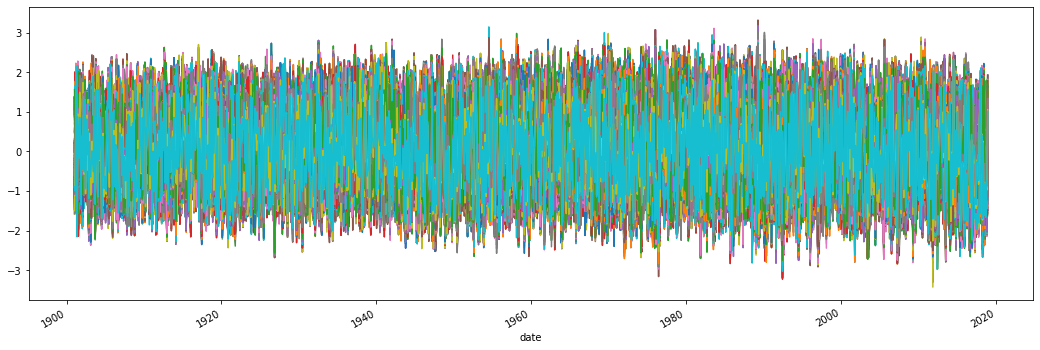

In [ ]:
spei_df.plot(legend=False)

### check null values

In [ ]:
np.where(pd.isnull(spei_df))

(array([], dtype=int64), array([], dtype=int64))

# Checking for drought

Where SPEI fell below -1 in any of those 4 months, the pointer year was
classed as a drought-linked pointer year.

Source: https://onlinelibrary.wiley.com/doi/full/10.1111/gcb.13366

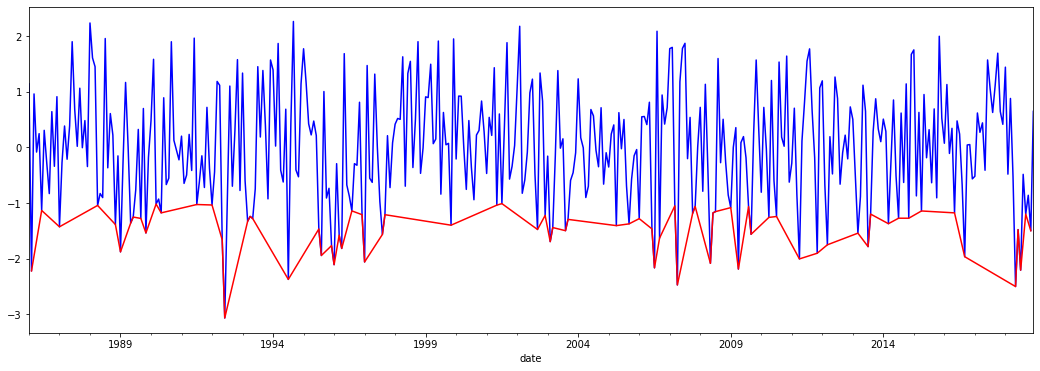

In [ ]:
fig, ax = plt.subplots()
#spei_df['aebe'][spei_df['aebe'] > 0].plot(ax=ax, c='b', legend=False)
spei_df['aebe'].plot(ax=ax, c='b', legend=False)
spei_df['aebe'][spei_df['aebe'] < -1].plot(ax=ax, c='r', legend=False)

## helper functions

In [ ]:
def check_drought_year(site):
  drought_years = []
  for idx, year in enumerate(spei_df.index.year.unique()):
    mar_2_aug = spei_df[(spei_df.index.month >= 5) & (spei_df.index.month <= 8)]
    site_df = mar_2_aug[site]
    year_df = site_df[site_df.index.year == year]
    if len(year_df[year_df < -1]) > 0:
      #print(year, 'drought')
      drought_years.append(year)
  return drought_years

def get_drought_idxs(site):
  bps = check_drought_year(site)
  copy_df = spei_df.copy()
  copy_df['Date'] = copy_df.index
  copy_df = copy_df.reset_index()
  idxs = []

  dates=[]
  for bp in bps:
    date = spei_df.index[spei_df.index.year == bp][5]
    dates.append(date)
  
  idxs = []
  for date in dates:
    idx = copy_df[copy_df['Date'] == date].index.tolist()
    idxs.extend(idx)

  idxs.append(len(spei_df))  
  return idxs

def plot_drought_years(site):
  fig, ax = plt.subplots()
  bps = check_drought_year(site)
  for bp in bps:
    date = spei_df.index[spei_df.index.year == bp][0]
    plt.axvline(date)
  return (fig,ax)

#check_drought_year('UK53')
#plot_drought_years('UK53')
idxs = get_drought_idxs('UK53')

In [ ]:
len(spei_df['UK52'])

1416

## class to run benchmarking

,algo,cp,cum_diff
0,bayes,None,None
1,pelt,"[55, 325, 330, 335, 355, 380, 385, 390]","[-1.004539627296623, -1.2551539935848126, -1.6..."
2,binseg,"[55, 325, 330, 335, 355, 380, 385, 390]","[-1.004539627296623, -1.2551539935848126, -1.6..."


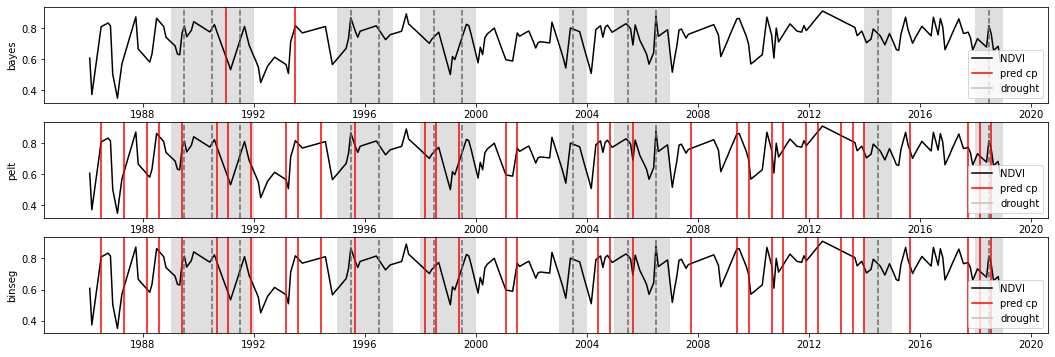

In [ ]:
algo_list = [
#('bayes' ,{'decomp_algo': 'STL', 'distribution': 'log_normal', 'log_odds_threshold': 0}),
('bayes', {'decomp_algo': 'STL', 'distribution': 'normal', 'log_odds_threshold': 0}),
('pelt', {'decomp_algo': 'STL'}),
('binseg', {'decomp_algo': 'STL'})]


class Drought:
  def __init__(self, year):
    '''
    cp_list : list of change point dates
    '''
    self.year = year
    self.cp_list = []
  


class Benchmark_Models:
  def __init__(self, algo_list):
    self.algo_list = algo_list
    self.result_df = None
    self.signal = None
    self.true_bps = None
  

  def linear_penalty(self, signal, b=0.045):
    return len(signal) * b

  def bic_penalty(self, signal, std=0.08):
    '''BICl2
    '''
    return float(len(signal) * np.log(len(signal)) * (np.std(signal)**2))

  def aic_penalty(self, signal, std=0.08):
    '''AICl2
    '''
    return float(len(signal) * (np.std(signal)**2))

  def extract_climate_trend(self, df, trend='STL'):
    '''
      input_params: 
        df: input the dataframe of which the trends are to be extracted from
            requirements for the dataframe:
            - dataframe index need to be datetime,
            - datetime index should be sorted
            - should be a monthly resampling
    '''
    climate_trend_df = pd.DataFrame()

    if trend == 'STL':
      yr_list = df.index.year
      #print(yr_list[-1])
      #print(yr_list[0])
      seasons = yr_list[-1] - yr_list[0]

      if seasons % 2 == 0:
        seasons += 1
      

      for col in df:
        stl = STL(df[col], period=12, seasonal=seasons, robust=True)
        res = stl.fit()
        #print(res.trend)
        climate_trend_df[col] = res.trend
        
    return climate_trend_df

  def get_decomp_plus_cp(self,signal, dates, decomp_algo='STL', cp_algo='bayes', config=None):
    '''
    task function

    description: applies decomposition, and gets the change points
    '''
    #formatting the np.array to dataframe for trend extraction
    signal = pd.DataFrame({'signal': signal})
    signal.index = dates

    
    #trend extraction
    if config:
      if 'decomp_algo' in config:
        decomp_algo = config['decomp_algo']
    if decomp_algo == 'STL':
      signal_trend = self.extract_climate_trend(signal, 'STL')
      signal = np.array(signal_trend['signal'])

    if decomp_algo == None:
      signal = np.array(signal)

    #change point detection

    #bayesian change point detection
    if cp_algo == 'bayes':
    #change point detection
      
      #assign config if exists
      if config:
        if 'distribution' in config:
          distribution = config['distribution']
        if 'log_odds_threshold' in config:
          log_odds = config['log_odds_threshold']
        detector = cpDetector([signal], distribution=distribution, log_odds_threshold=log_odds)
      #else use log normal and 0 treshold
      else:
        detector = cpDetector([signal], distribution='log_normal', log_odds_threshold=0)
      detector.detect_cp()
      
      
      #gets the breakpoints via idx from the detector
      predicted_breaks = detector.change_points['traj_0']['ts'].values
      predicted_breaks = np.append(predicted_breaks, len(signal))

    pen = self.aic_penalty(signal)

    if cp_algo == 'pelt':
      model = 'rbf'
      #pen= 10
      if config:
        if 'model' in config:
          model = config['model']
        if 'pen' in config:
          pen = config['pen']
      algo = rpt.Pelt(model=model).fit(signal)
      #gets the breakpoints via idx from the detector
      predicted_breaks = algo.predict(pen=pen) #may need to change the 10


    if cp_algo == 'binseg':
      algo = rpt.Binseg(model='rbf').fit(signal)
      predicted_breaks = algo.predict(pen=pen)

    if cp_algo == 'window':
      width = 10
      model = 'rbf'
      std = 0.045
      #cost = rpt.costs.CostRank().fit(signal)
      if config:
        if 'width' in config:
          width = config['width']
        if 'model' in config:
          model = config['model']
        if 'std' in config:
          std = config['std']
      n_bkps = 3*len(signal)*std**2

      algo = rpt.Window(width=width).fit(signal)
      predicted_breaks = algo.predict(pen=pen)

    return predicted_breaks



  def run_single_search(self, signal, real_bps, algo):
    '''
    handler function
    description:
    '''
    

    bp = self.get_decomp_plus_cp(signal, signal.index, cp_algo=algo[0], config=algo[1])
    return bp
    
  


  def get_scores(self, bp, bp_list):
    h_score = hausdorff(bp, bp_list)
    rand_score = randindex(bp, bp_list)
    recall_score = precision_recall(bp, bp_list)

    return (h_score, rand_score, recall_score)

  def run_benchmark(self, signal, real_bps):
    '''
      signal: list
      real_bp: list of idx of breakpoints
    '''

    #initialize the result variables
    f1_score = None
    recall_score = None
    h_score = None
    rand_score = None
    params = None
    ann_err = None
    self.signal = signal
    bps = None
    self.true_bps = real_bps

    self.df = pd.DataFrame({'signal':[signal.values] * len(self.algo_list),
                            'algo': [None] * len(self.algo_list),
                            'f1_score': [f1_score] * len(self.algo_list),
                            'h_score': [h_score] * len(self.algo_list),
                            'randindex': [rand_score] * len(self.algo_list),
                            'ann_err': [ann_err] * len(self.algo_list),
                            'pred_bp': [bps] * len(self.algo_list)
                            }) 

    
    for idx, algo in enumerate(self.algo_list):
      f1_score = None
      recall_score = None
      h_score = None
      rand_score = None
      params = None
      
      #print(algo[0])
      bp = self.run_single_search(signal, real_bps, algo)
      if type(bp) == np.ndarray:
        #print('check')
        bp = list(bp)
      signal_length = len(signal)
      # if there are breakpoints
      if (type(bp) == list) & (len(bp) > 1):
 

        #calculate scores
        h_score, rand_score, recall_score = self.get_scores(bp, real_bps)

        if recall_score != (None, None):
          if recall_score[0] != 0 and recall_score[1] != 0: #prevent error zero division error
            f1_score = 2 * (recall_score[0] * recall_score[1]) / (recall_score[0] + recall_score[1])
      self.df['f1_score'][idx] = f1_score
      self.df['h_score'][idx] = h_score
      self.df['ann_err'][idx] = len(bp) - len(real_bps)
      self.df['randindex'][idx] = rand_score
      self.df['pred_bp'][idx] = bp
      self.df['algo'][idx] = algo[0]
     

    return self.df

  def get_casual_impacts(self, all_formatted_data_df, only_neg=False):
    '''
    '''
    out_df = pd.DataFrame({
        'algo': [None] * len(self.df),
        'cp' : [None] * len(self.df),
        'cum_diff' : [None] * len(self.df)
    })

    for row_idx, row in self.df.iterrows():
      out_df.iloc[row_idx]['algo'] = row['algo']
      if row_idx > 0:
        row_neg_cp_list = []
        row_neg_cum_list = []
        for cp_idx, cp in enumerate(row['pred_bp']):
          # casual impact first 13 observations were removed due to approximate diffuse initialization
          if cp > 13 and cp != len(self.signal):
            pre_period = [self.signal.index[0], self.signal.index[cp]]
            post_period = [self.signal.index[cp+1], self.signal.index[-1]]

            all_formatted_data_df = all_formatted_data_df[['y','x0', 'x1', 'x2', 'x3', 'x4']]

            ci = CausalImpact(all_formatted_data_df, pre_period, post_period,  nseasons=[{'period':12}])

            if only_neg == True:
              if ci.inferences.iloc[-1]['post_cum_y'] - ci.inferences.iloc[-1]['post_cum_pred'] < 0:
                row_neg_cp_list.append(cp)
                row_neg_cum_list.append(ci.inferences.iloc[-1]['post_cum_y'] - ci.inferences.iloc[-1]['post_cum_pred'])
            else:
              row_neg_cp_list.append(cp)
              row_neg_cum_list.append(ci.inferences.iloc[-1]['post_cum_y'] - ci.inferences.iloc[-1]['post_cum_pred'])

        out_df.iloc[row_idx]['cp'] = row_neg_cp_list
        out_df.iloc[row_idx]['cum_diff'] = row_neg_cum_list
    
    return out_df


  def plot(self, selected_cp=None):

    fig, ax = plt.subplots(len(self.algo_list),1)

    for idx, algo in enumerate(algo_list):
      ax[idx].plot(self.signal, c='black')
      if selected_cp == None:
        for bp in self.df['pred_bp'][idx][:-1]:
          ax[idx].axvline(self.signal.index[bp], c='r')
      else:
        ax[idx].axvline(self.signal.index[selected_cp], c='r')
      for real_bp in self.true_bps[:-1]:
        ax[idx].axvline(self.signal.index[real_bp], c='dimgray',ls='--')

        # draws the left hand side of the graph
        if real_bp - 6 >= 0:
          shaded_left_idx = self.signal.index[real_bp - 6] 
        else:
          shaded_left_idx = self.signal.index[0]
        ax[idx].axvspan(shaded_left_idx,self.signal.index[real_bp], facecolor='silver', alpha=0.5)


        # draws the right hand side of the graph
        if real_bp + 6 < len(self.signal):
          shaded_right_idx = self.signal.index[real_bp + 6] 
        else:
          shaded_right_idx = self.signal.index[-1]
        ax[idx].axvspan(self.signal.index[real_bp], shaded_right_idx, facecolor='silver', alpha=0.5)

      ax[idx].legend(('NDVI','pred cp','drought'))
      ax[idx].set_ylabel(algo[0])
      leg = ax[idx].get_legend()
      leg.legendHandles[0].set_color('black')
      leg.legendHandles[1].set_color('red')
      leg.legendHandles[2].set_color('silver')


site_id = 'UK53'

# running benchmark
true_bp = check_drought_year(site_id)
bm = Benchmark_Models(algo_list)
true_idxs = get_drought_idxs(site_id)
df = bm.run_benchmark(harm_df[site_id], true_idxs)

# getting all the casual impacts
all_data_df = get_climate_and_ndvi(site_id)
all_formatted_data_df = format_cols_casualimpact(all_data_df, 'ndvi')
neg_ci_df = bm.get_casual_impacts(all_formatted_data_df, only_neg=True)
display(neg_ci_df)
bm.plot()

### swit345

,algo,cp,cum_diff
0,bayes,None,None
1,pelt,"[140, 150, 170, 175]","[-0.32291462432414164, -2.613332525088367, -1...."
2,binseg,"[140, 150, 170, 175]","[-0.32291462432414164, -2.613332525088367, -1...."


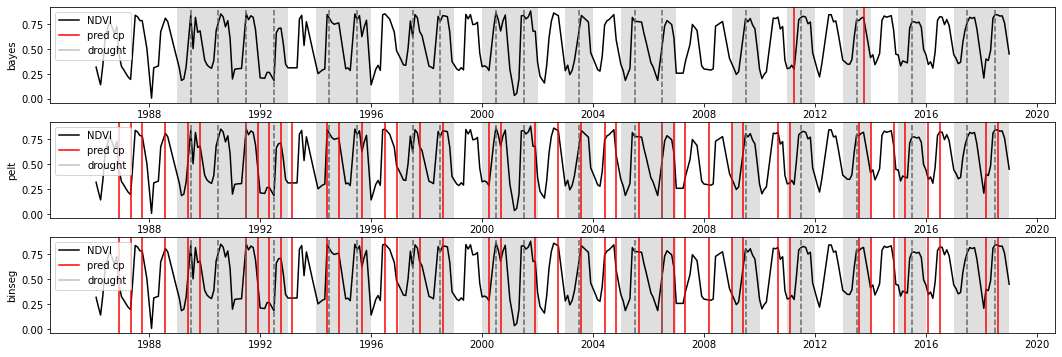

In [ ]:
site_id = 'SWIT345'

# running benchmark
true_bp = check_drought_year(site_id)
bm = Benchmark_Models(algo_list)
true_idxs = get_drought_idxs(site_id)
df = bm.run_benchmark(harm_df[site_id], true_idxs)

# getting all the casual impacts
all_data_df = get_climate_and_ndvi(site_id)
all_formatted_data_df = format_cols_casualimpact(all_data_df, 'ndvi')
neg_ci_df = bm.get_casual_impacts(all_formatted_data_df, only_neg=True)
display(neg_ci_df)
bm.plot()

"E45" "FSAR" "FSGA" "GoS"

### GoS

,algo,cp,cum_diff
0,bayes,None,None
1,pelt,"[370, 390]","[-0.9942115635251945, -0.1833026643800344]"
2,binseg,"[370, 390]","[-0.9942115635251945, -0.1833026643800344]"


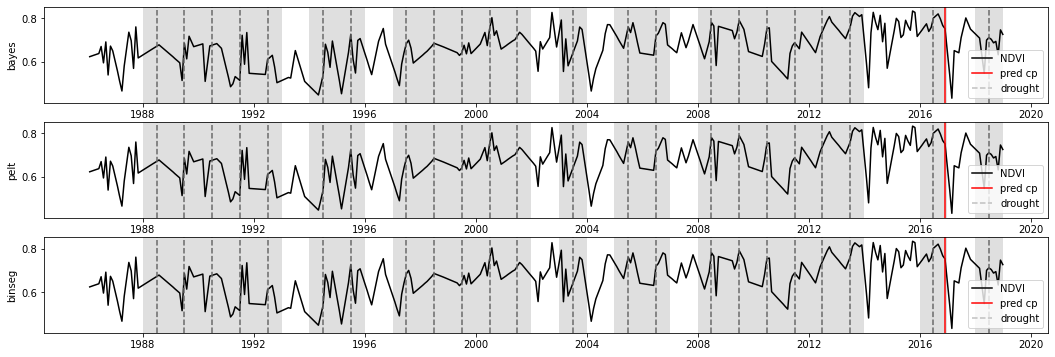

In [ ]:
site_id = 'GoS'

# running benchmark
true_bp = check_drought_year(site_id)
bm = Benchmark_Models(algo_list)
true_idxs = get_drought_idxs(site_id)
df = bm.run_benchmark(harm_df[site_id], true_idxs)

# getting all the casual impacts
all_data_df = get_climate_and_ndvi(site_id)
all_formatted_data_df = format_cols_casualimpact(all_data_df, 'ndvi')
neg_ci_df = bm.get_casual_impacts(all_formatted_data_df, only_neg=True)
display(neg_ci_df)
# selecteing change point displayed in neg_ci_df
bm.plot(selected_cp=390)

In [ ]:
investigating_cp = 390

def model

In [ ]:
bm.df

,signal,algo,f1_score,h_score,randindex,ann_err,pred_bp
0,"[0.6073940124573036, 0.3722794959908362, 0.481...",bayes,0.142857,300,0.356826,-10,"[89, 59, 396]"
1,"[0.6073940124573036, 0.3722794959908362, 0.481...",pelt,0.391304,46,0.89533,22,"[5, 15, 25, 30, 40, 55, 60, 70, 85, 90, 100, 1..."
2,"[0.6073940124573036, 0.3722794959908362, 0.481...",binseg,0.391304,46,0.89533,22,"[5, 15, 25, 30, 40, 55, 60, 70, 85, 90, 100, 1..."


# univariate lstm

# multivariate lstm

## multiple input series

### multiple parallel input and multi-step output

In [ ]:
site = 'SWIT345'
all_data_df = get_climate_and_ndvi(site)
display(all_data_df)

,pp,rr,tg,tn,tx,ndvi
Date,,,,,,
1986-01-31,1013.900015,4.864516,0.975806,-1.707742,4.251935,0.318780
1986-02-28,1011.242872,1.735714,-1.354286,-3.848571,1.692143,0.230058
1986-03-31,1017.496789,1.303226,5.091613,1.864516,9.023226,0.141337
1986-04-30,1010.876682,14.556667,6.509667,3.884333,9.810333,0.338837
1986-05-31,1017.780660,5.577419,15.047096,10.819677,20.320645,0.623102
...,...,...,...,...,...,...
2018-08-31,1015.622596,4.951613,21.207419,16.348709,27.032257,0.830514
2018-09-30,1019.583349,0.940000,17.796333,13.199000,23.126333,0.832393
2018-10-31,1017.651628,9.716129,13.152258,9.296451,17.583225,0.760072


In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

# choose a number of time steps
n_steps_in, n_steps_out = 6, 6 #have to make a config

# covert into input/output
X, y = split_sequences(np.array(all_data_df), n_steps_in, n_steps_out)
print(X.shape, y.shape)

n_features = 5#X.shape[2]

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val =\
  train_test_split(X_train, y_train, test_size=0.25, random_state=1) 

print(train_X.shape, train_y.shape)
print(val_X.shape, val_y.shape)
print(test_X.shape, test_y.shape)

(385, 6, 6) (385, 6, 6)
(275, 3, 5) (275,)
(37, 3, 5) (37,)
(78, 3, 5) (78,)


In [ ]:
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')

In [ ]:
tf.random.set_seed(1)
np.random.seed(1)

import os

folder_path = '/model_data/' + site

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# model_weight_loc = os.getcwd() + '/model_data/' + site + '/best_BiLSTM_model.h5'
model_weight_loc = folder_path + 'best_BiLSTM_model.h5'
mc = ModelCheckpoint(model_weight_loc, monitor='val_loss', mode='min', save_best_only=True)
# fit model
history = model.fit(train_X, train_y, epochs=400, verbose=1, validation_data=(val_X, val_y), callbacks=[mc])

Epoch 1/400


InvalidArgumentError: ignored

In [ ]:
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=400, verbose=0)
# demonstrate prediction
x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

NameError: ignored

### Multiple streams LSTM

In [ ]:
site = 'SWIT345'
all_data_df = get_climate_and_ndvi(site)
display(all_data_df)

,pp,rr,tg,tn,tx,ndvi
Date,,,,,,
1986-01-31,1013.900015,4.864516,0.975806,-1.707742,4.251935,0.318780
1986-02-28,1011.242872,1.735714,-1.354286,-3.848571,1.692143,0.230058
1986-03-31,1017.496789,1.303226,5.091613,1.864516,9.023226,0.141337
1986-04-30,1010.876682,14.556667,6.509667,3.884333,9.810333,0.338837
1986-05-31,1017.780660,5.577419,15.047096,10.819677,20.320645,0.623102
...,...,...,...,...,...,...
2018-08-31,1015.622596,4.951613,21.207419,16.348709,27.032257,0.830514
2018-09-30,1019.583349,0.940000,17.796333,13.199000,23.126333,0.832393
2018-10-31,1017.651628,9.716129,13.152258,9.296451,17.583225,0.760072


In [ ]:
np.array(all_data_df)

array([[ 1.01390002e+03,  4.86451620e+00,  9.75806430e-01,
        -1.70774190e+00,  4.25193539e+00,  3.18779590e-01],
       [ 1.01124287e+03,  1.73571431e+00, -1.35428568e+00,
        -3.84857134e+00,  1.69214282e+00,  2.30058312e-01],
       [ 1.01749679e+03,  1.30322583e+00,  5.09161279e+00,
         1.86451609e+00,  9.02322560e+00,  1.41337034e-01],
       ...,
       [ 1.01765163e+03,  9.71612918e+00,  1.31522578e+01,
         9.29645141e+00,  1.75832254e+01,  7.60071542e-01],
       [ 1.01929335e+03,  3.97333339e+00,  7.28533317e+00,
         5.07666655e+00,  9.86999978e+00,  6.05177426e-01],
       [ 1.02219034e+03,  7.93548399e-01,  3.47903218e+00,
        -2.22580640e-02,  7.41096758e+00,  4.50283309e-01]])

In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
dataset = np.array(all_data_df)
print(dataset.shape)

train_end = int(len(dataset) * 0.7)
val_end = int(len(dataset) * 0.8)

train_dataset = dataset[: train_end]
val_dataset = dataset[train_end : val_end]
test_dataset = dataset[val_end:]


# choose a number of time steps
n_steps = 3
n_features = len(all_data_df.columns) - 1

# convert into input/output
X, y = split_sequences(train_dataset, n_steps)


X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val =\
  train_test_split(X_train, y_train, test_size=0.25, random_state=1) 

print(train_X.shape, train_y.shape)
print(val_X.shape, val_y.shape)
print(test_X.shape, test_y.shape)

# summarize the data
for i in range(len(X)):
  if i < 5:
	  print(X[i], y[i])
 

(396, 6)
(275, 3, 5) (275,)
(37, 3, 5) (37,)
(78, 3, 5) (78,)
[[ 1.01390002e+03  4.86451620e+00  9.75806430e-01 -1.70774190e+00
   4.25193539e+00]
 [ 1.01124287e+03  1.73571431e+00 -1.35428568e+00 -3.84857134e+00
   1.69214282e+00]
 [ 1.01749679e+03  1.30322583e+00  5.09161279e+00  1.86451609e+00
   9.02322560e+00]] 0.14133703446680546
[[1011.24287221    1.73571431   -1.35428568   -3.84857134    1.69214282]
 [1017.49678936    1.30322583    5.09161279    1.86451609    9.0232256 ]
 [1010.87668173   14.55666688    6.50966652    3.88433325    9.81033311]] 0.3388370423546303
[[1017.49678936    1.30322583    5.09161279    1.86451609    9.0232256 ]
 [1010.87668173   14.55666688    6.50966652    3.88433325    9.81033311]
 [1017.78066033    5.57741944   15.04709644   10.81967718   20.32064471]] 0.6231017027151403
[[1010.87668173   14.55666688    6.50966652    3.88433325    9.81033311]
 [1017.78066033    5.57741944   15.04709644   10.81967718   20.32064471]
 [1014.33334845    2.71000004   17.219

#### LSTM

In [ ]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
tf.random.set_seed(1)
np.random.seed(1)

# fit model
model.fit(train_X, train_y, epochs=400, verbose=1)

Epoch 1/400
9/9 [==============================] - 0s 6ms/step - loss: 3790.8740
Epoch 2/400
9/9 [==============================] - 0s 5ms/step - loss: 1274.1376
Epoch 3/400
9/9 [==============================] - 0s 7ms/step - loss: 162.5468
Epoch 4/400
9/9 [==============================] - 0s 5ms/step - loss: 29.1535
Epoch 5/400
9/9 [==============================] - 0s 5ms/step - loss: 19.1272
Epoch 6/400
9/9 [==============================] - 0s 6ms/step - loss: 8.2633
Epoch 7/400
9/9 [==============================] - 0s 5ms/step - loss: 4.2515
Epoch 8/400
9/9 [==============================] - 0s 5ms/step - loss: 1.4472
Epoch 9/400
9/9 [==============================] - 0s 5ms/step - loss: 0.9619
Epoch 10/400
9/9 [==============================] - 0s 5ms/step - loss: 0.7804
Epoch 11/400
9/9 [==============================] - 0s 6ms/step - loss: 0.5745
Epoch 12/400
9/9 [==============================] - 0s 6ms/step - loss: 0.5558
Epoch 13/400
9/9 [==============================] -

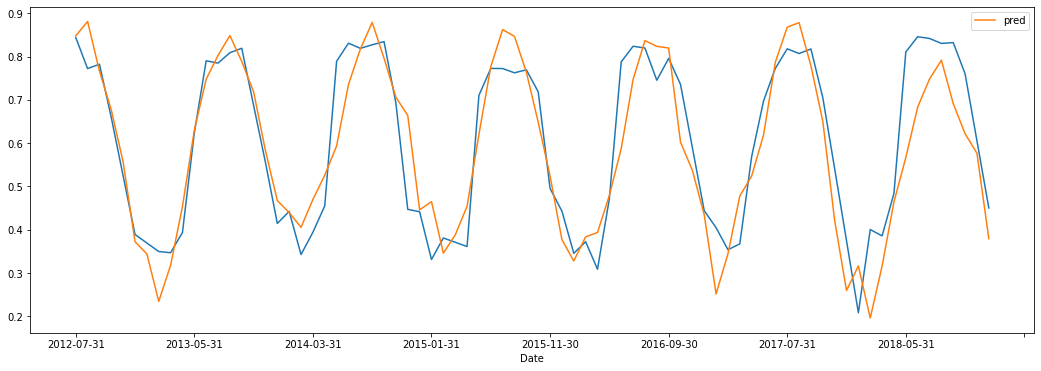

In [ ]:
yhat = model.predict(test_X, verbose=0)

predictions = pd.DataFrame({'pred': yhat.reshape(yhat.shape[0])}, index=all_data_df.index[-yhat.shape[0]:] )

fig, ax = plt.subplots()
all_data_df['ndvi'][-yhat.shape[0]:].plot(ax=ax)
predictions.plot(ax=ax)


#### BiLSTM

In [ ]:
# define model
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
tf.random.set_seed(1)
np.random.seed(1)

import os

folder_path = '/model_data/' + site

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# model_weight_loc = os.getcwd() + '/model_data/' + site + '/best_BiLSTM_model.h5'
model_weight_loc = folder_path + 'best_BiLSTM_model.h5'
mc = ModelCheckpoint(model_weight_loc, monitor='val_loss', mode='min', save_best_only=True)
# fit model
history = model.fit(train_X, train_y, epochs=400, verbose=1, validation_data=(val_X, val_y), callbacks=[mc])

Epoch 1/400
9/9 [==============================] - 0s 42ms/step - loss: 2330.4509 - val_loss: 60.9135
Epoch 2/400
9/9 [==============================] - 0s 14ms/step - loss: 61.7623 - val_loss: 41.2924
Epoch 3/400
9/9 [==============================] - 0s 14ms/step - loss: 16.9538 - val_loss: 29.1349
Epoch 4/400
9/9 [==============================] - 0s 14ms/step - loss: 11.6301 - val_loss: 7.9909
Epoch 5/400
9/9 [==============================] - 0s 14ms/step - loss: 6.5992 - val_loss: 2.4817
Epoch 6/400
9/9 [==============================] - 0s 12ms/step - loss: 3.3661 - val_loss: 2.9012
Epoch 7/400
9/9 [==============================] - 0s 11ms/step - loss: 2.2399 - val_loss: 2.4957
Epoch 8/400
9/9 [==============================] - 0s 14ms/step - loss: 1.7204 - val_loss: 1.8751
Epoch 9/400
9/9 [==============================] - 0s 14ms/step - loss: 1.4895 - val_loss: 1.3983
Epoch 10/400
9/9 [==============================] - 0s 14ms/step - loss: 1.1963 - val_loss: 1.1034
Epoch 11/4

In [ ]:
saved_model = load_model(model_weight_loc)

In [ ]:
val_loss = saved_model.evaluate(val_X, val_y, verbose=0)
test_loss = saved_model.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (val_loss, test_loss))

Train: 0.018, Test: 0.038


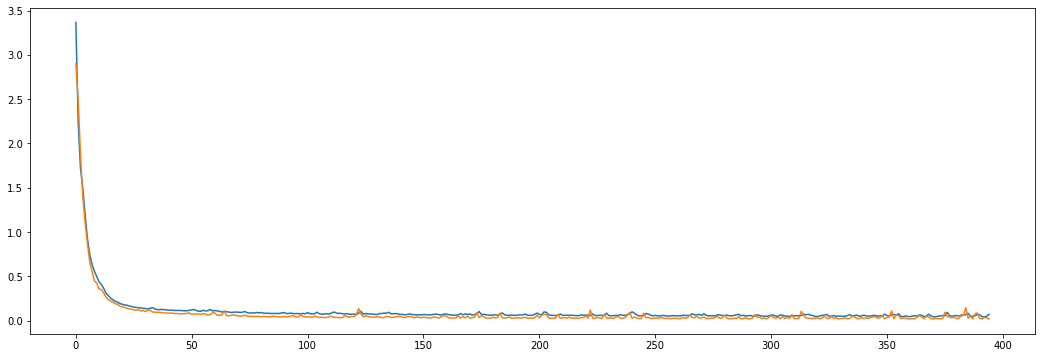

In [ ]:
plt.plot(history.history['loss'][5:])
plt.plot(history.history['val_loss'][5:])

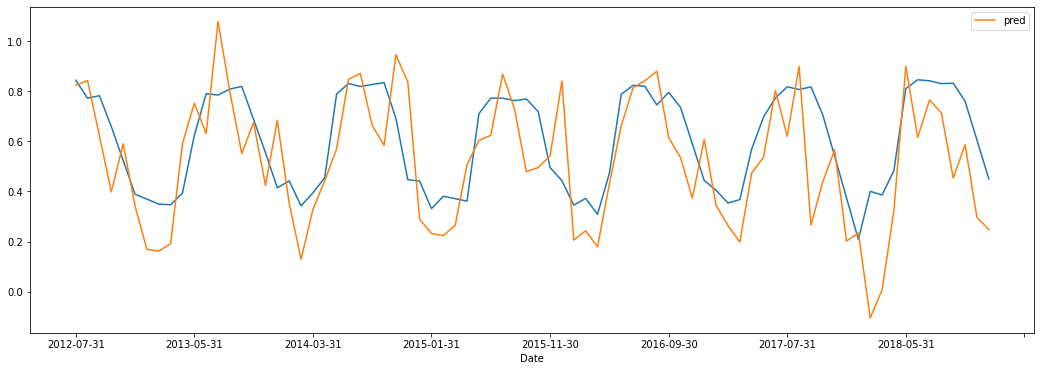

In [ ]:
yhat = saved_model.predict(test_X, verbose=0)

predictions = pd.DataFrame({'pred': yhat.reshape(yhat.shape[0])}, index=all_data_df.index[-yhat.shape[0]:] )

fig, ax = plt.subplots()
all_data_df['ndvi'][-yhat.shape[0]:].plot(ax=ax)
predictions.plot(ax=ax)


# calculate casual effect of treatment

,signal,algo,f1_score,h_score,randindex,ann_err,pred_bp
0,"[0.6073940124573036, 0.3722794959908362, 0.481...",bayes,0.142857,300,0.356826,-10,"[89, 59, 396]"
1,"[0.6073940124573036, 0.3722794959908362, 0.481...",pelt,0.391304,46,0.89533,22,"[5, 15, 25, 30, 40, 55, 60, 70, 85, 90, 100, 1..."
2,"[0.6073940124573036, 0.3722794959908362, 0.481...",binseg,0.391304,46,0.89533,22,"[5, 15, 25, 30, 40, 55, 60, 70, 85, 90, 100, 1..."


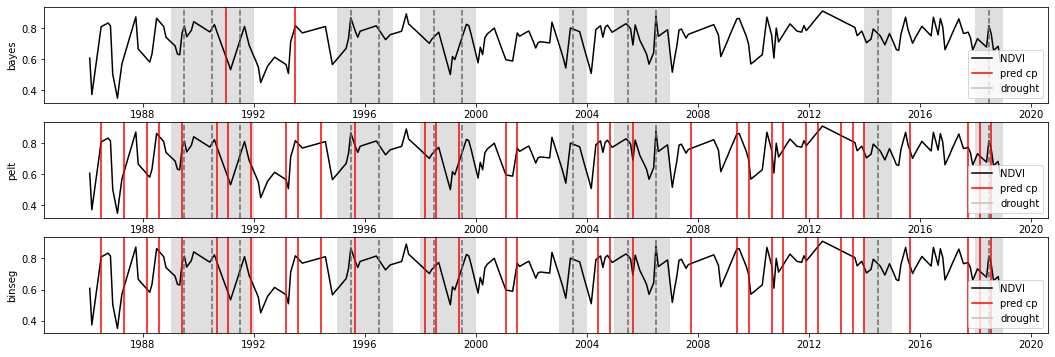

In [ ]:
display(bm.df)
bm.plot()

# transformer

In [ ]:
! pip install mxnet gluonts

     |████████████████████████████████| 419kB 4.7MB/s 
     |████████████████████████████████| 194kB 13.3MB/s 
     |████████████████████████████████| 8.7MB 17.6MB/s 
  Created wheel for ujson: filename=ujson-1.35-cp36-cp36m-linux_x86_64.whl size=68020 sha256=9f793c81987d5e64f0b7cc3f4809cd8b5c28b235d4cb2d7451b764718fef9ee0
  Stored in directory: /root/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
Successfully built ujson


In [ ]:
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [ ]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
% cd /content/gdrive/'My Drive'/water_stress_detection

/content/gdrive/My Drive/water_stress_detection


In [ ]:
! git clone https://github.com/maxjcohen/transformer.git

Cloning into 'transformer'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 1163 (delta 53), reused 75 (delta 31), pack-reused 1051
Receiving objects: 100% (1163/1163), 56.45 MiB | 5.40 MiB/s, done.
Resolving deltas: 100% (655/655), done.
Checking out files: 100% (82/82), done.


In [ ]:
! ls transformer/tst

decoder.py  __init__.py  multiHeadAttention.py	     transformer.py
encoder.py  loss.py	 positionwiseFeedForward.py  utils.py


In [ ]:
import datetime

import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns

# transformer needs to be rehosted

from transformer.tst import Transformer
from transformer.tst.loss import OZELoss

from transformer.src.dataset import OzeDataset
from transformer.src.utils import compute_loss
from transformer.src.visualization import map_plot_function, plot_values_distribution, plot_error_distribution, plot_errors_threshold, plot_visual_sample

In [ ]:
OzeDataset

transformer.src.dataset.OzeDataset

# calculate how many change points appear within the drought per method

In [ ]:
print('done')

done


In [ ]:
algo_count = {}


for site in harm_df.columns:
  true_bp = check_drought_year(site)
  # print(len(true_bp))
  bm = Benchmark_Models(algo_list)
  true_idxs = get_drought_idxs(site)
  signal = harm_df[site]
  df = bm.run_benchmark(signal, true_idxs)

  for row_idx, row in bm.df.iterrows():
    if row['algo'] not in algo_count.keys():
      algo_count[row['algo']] = {'in': 0, 'total': 0}
      
    for bp in row['pred_bp']:
      if bp != len(signal):
        algo_count[row['algo']]['total'] += 1
        if signal.index[bp].year in true_bp:
          algo_count[row['algo']]['in'] += 1

algo_count

{'bayes': {'in': 916, 'total': 1388},
 'binseg': {'in': 11041, 'total': 16843},
 'pelt': {'in': 11396, 'total': 17386}}

In [ ]:
for algo in algo_count:
  print(algo , algo_count[algo]['in'] / algo_count[algo]['total'] * 100)

bayes 65.99423631123919
pelt 65.54699183250892
binseg 65.55245502582675


### UK53

,algo,cp,cum_diff
0,bayes,None,None
1,pelt,"[55, 325, 330, 335, 355, 380, 385, 390]","[-1.004539627296623, -1.2551539935848126, -1.6..."
2,binseg,"[55, 325, 330, 335, 355, 380, 385, 390]","[-1.004539627296623, -1.2551539935848126, -1.6..."


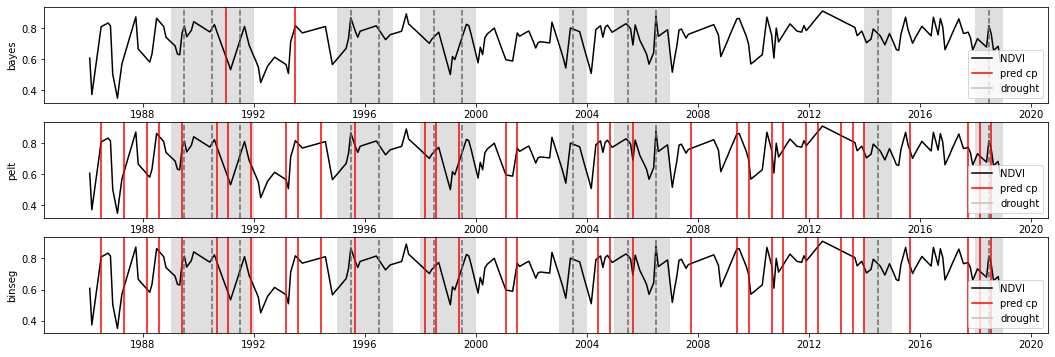

In [ ]:
site_id = 'UK53'

true_bp = check_drought_year(site_id)
bm = Benchmark_Models(algo_list)
true_idxs = get_drought_idxs(site_id)

signal = harm_df[site_id]


df = bm.run_benchmark(signal, true_idxs)
bm.plot()


all_data_df = get_climate_and_ndvi(site_id)
all_formatted_data_df = format_cols_casualimpact(all_data_df, 'ndvi')


init_dict = {}

out_df = pd.DataFrame({
    'algo': [None] * len(bm.df),
    'cp' : [None] * len(bm.df),
    'cum_diff' : [None] * len(bm.df)
})

for row_idx, row in bm.df.iterrows():
  out_df.iloc[row_idx]['algo'] = row['algo']
  if row_idx > 0:
    row_neg_cp_list = []
    row_neg_cum_list = []
    for cp_idx, cp in enumerate(row['pred_bp']):
      # casual impact first 13 observations were removed due to approximate diffuse initialization
      if cp > 13 and cp != len(signal):
        pre_period = [signal.index[0], signal.index[cp]]
        post_period = [signal.index[cp+1], signal.index[-1]]

        all_formatted_data_df = all_formatted_data_df[['y','x0', 'x1', 'x2', 'x3', 'x4']]

        ci = CausalImpact(all_formatted_data_df, pre_period, post_period,  nseasons=[{'period':12}])
        # ci.plot()
        # print(ci.trained_model.params)
        # print(ci.summary())

        if ci.inferences.iloc[-1]['post_cum_y'] - ci.inferences.iloc[-1]['post_cum_pred'] < 0:
          # print(ci.inferences.iloc[-1]['post_cum_y'] - ci.inferences.iloc[-1]['post_cum_pred'])
          row_neg_cp_list.append(cp)
          row_neg_cum_list.append(ci.inferences.iloc[-1]['post_cum_y'] - ci.inferences.iloc[-1]['post_cum_pred'])
        # print('6 month:', ci.inferences.iloc[cp+6]['post_cum_y'] - ci.inferences.iloc[cp+6]['post_cum_pred'])
        # print('1 year:', ci.inferences.iloc[cp+12]['post_cum_y'] - ci.inferences.iloc[cp+12]['post_cum_pred'])
        # print('2 year:',ci.inferences.iloc[cp+24]['post_cum_y'] - ci.inferences.iloc[cp+24]['post_cum_pred'])


        #print(row_idx, signal.index[cp].year in true_bp ,signal.index[cp], ci.inferences.iloc[-1]['post_cum_y'] - ci.inferences.iloc[-1]['post_cum_pred'])
  
    out_df.iloc[row_idx]['cp'] = row_neg_cp_list
    out_df.iloc[row_idx]['cum_diff'] = row_neg_cum_list

out_df


### SWIT345

[1989, 1990, 1991, 1992, 1994, 1995, 1997, 1998, 2000, 2001, 2003, 2005, 2006, 2009, 2011, 2013, 2015, 2017, 2018]


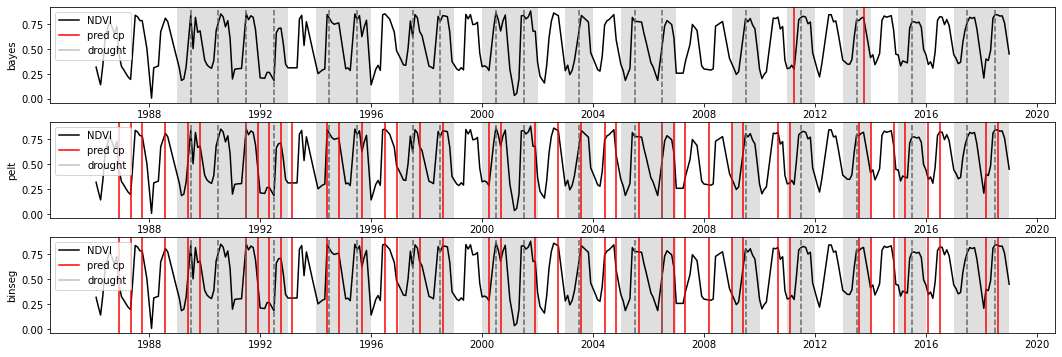

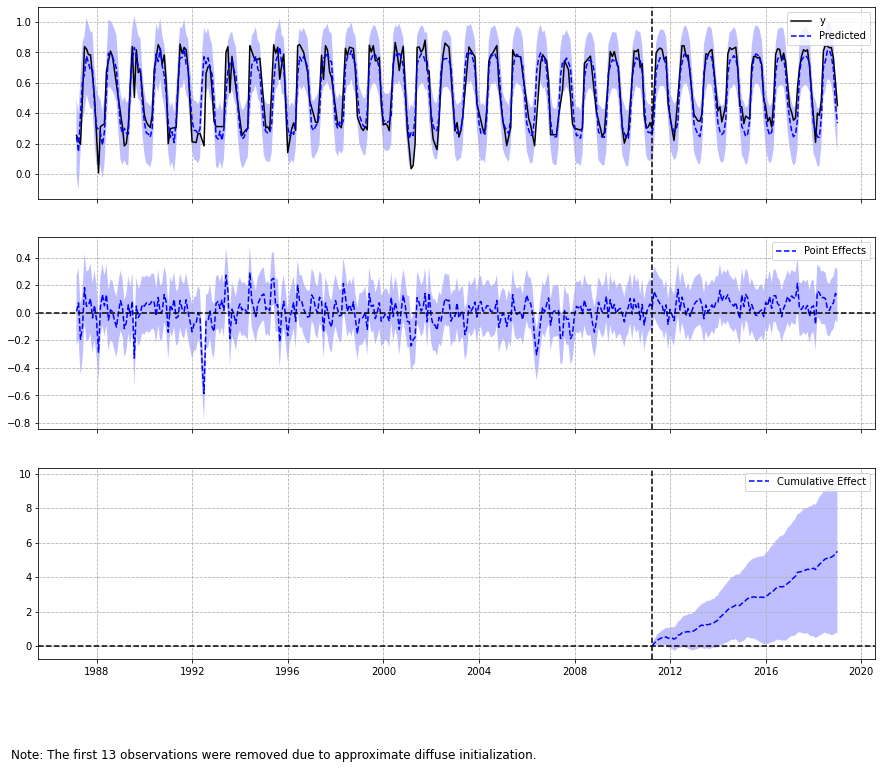

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.6                56.1
Prediction (s.d.)         0.54 (0.02)        50.61 (2.32)
95% CI                    [0.5, 0.59]        [46.25, 55.33]

Absolute effect (s.d.)    0.06 (0.02)        5.49 (2.32)
95% CI                    [0.01, 0.11]       [0.78, 9.85]

Relative effect (s.d.)    10.86% (4.58%)     10.86% (4.58%)
95% CI                    [1.53%, 19.47%]    [1.53%, 19.47%]

Posterior tail-area probability p: 0.01
Posterior prob. of a causal effect: 98.9%

For more details run the command: print(impact.summary('report'))
6 month: 0.4746259794411989
1 year: 0.464016815623312
2 year: 1.1601191543027412


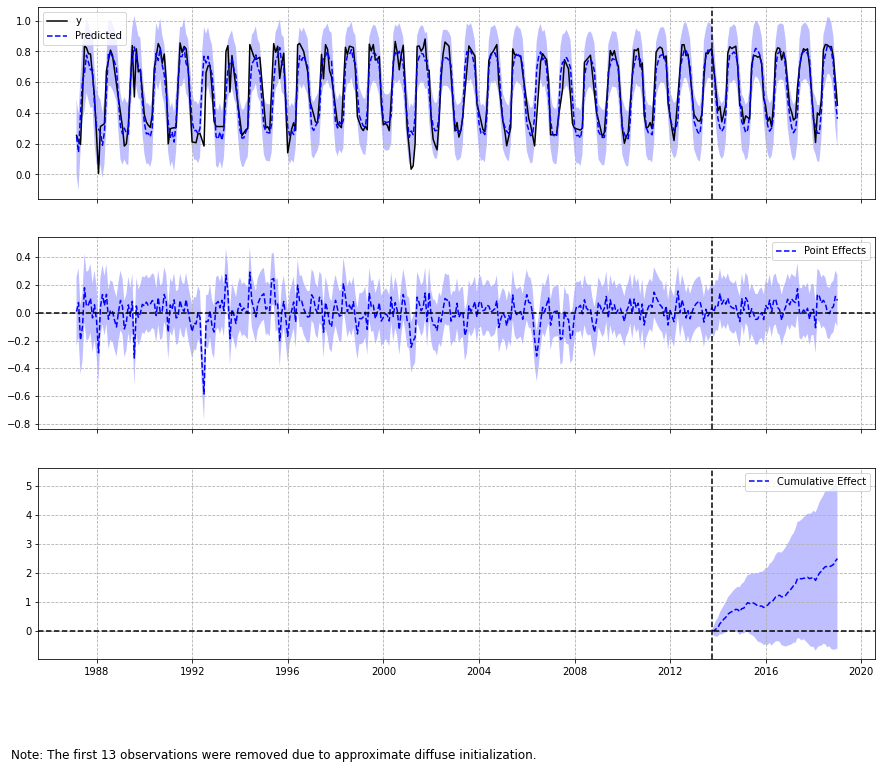

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.6                37.79
Prediction (s.d.)         0.56 (0.02)        35.3 (1.51)
95% CI                    [0.52, 0.61]       [32.47, 38.4]

Absolute effect (s.d.)    0.04 (0.02)        2.49 (1.51)
95% CI                    [-0.01, 0.08]      [-0.61, 5.32]

Relative effect (s.d.)    7.05% (4.28%)      7.05% (4.28%)
95% CI                    [-1.73%, 15.06%]   [-1.73%, 15.06%]

Posterior tail-area probability p: 0.05
Posterior prob. of a causal effect: 94.81%

For more details run the command: print(impact.summary('report'))
6 month: 0.4041690705498908
1 year: 0.7422460471373196
2 year: 0.8528570920190877


In [ ]:
print(true_bp)

site_id = 'SWIT345'

true_bp = check_drought_year(site_id)
bm = Benchmark_Models(algo_list)
true_idxs = get_drought_idxs(site_id)

signal = harm_df[site_id]

# yr_list = signal.index.year
# seasons = yr_list[-1] - yr_list[0]
# if seasons % 2 == 0:
#   seasons += 1

# stl = STL(signal, period=12, seasonal=seasons, robust=True)
# res = stl.fit()
# res.plot()


df = bm.run_benchmark(signal, true_idxs)
bm.plot()


all_data_df = get_climate_and_ndvi(site_id)
all_formatted_data_df = format_cols_casualimpact(all_data_df, 'ndvi')
all_formatted_data_df


for row_idx, row in bm.df.iterrows():
  if row_idx == 0:
    for cp_idx, cp in enumerate(row['pred_bp']):
      if cp >= 0 and cp != len(signal):
        pre_period = [signal.index[0], signal.index[cp]]
        post_period = [signal.index[cp+1], signal.index[-1]]

        # yr_list = signal.index.year
        # seasons = yr_list[-1] - yr_list[0]
        # if seasons % 2 == 0:
        #   seasons += 1
        # for col in all_formatted_data_df.keys():
        #   stl = STL(all_formatted_data_df[col], period=12, seasonal=seasons, robust=True)
        #   res = stl.fit()
        #   all_formatted_data_df[col] = res.trend

        all_formatted_data_df = all_formatted_data_df[['y', 'x2', 'x3', 'x4']]

        ci = CausalImpact(all_formatted_data_df, pre_period, post_period, nseasons=[{'period':12}])
        ci.plot()
        # print(ci.trained_model.params)
        print(ci.summary())
        #if ci.inferences.iloc[-1]['post_cum_y'] - ci.inferences.iloc[-1]['post_cum_pred'] < 0:

        print('6 month:', ci.inferences.iloc[cp+6]['post_cum_y'] - ci.inferences.iloc[cp+6]['post_cum_pred'])
        print('1 year:', ci.inferences.iloc[cp+12]['post_cum_y'] - ci.inferences.iloc[cp+12]['post_cum_pred'])
        print('2 year:',ci.inferences.iloc[cp+24]['post_cum_y'] - ci.inferences.iloc[cp+24]['post_cum_pred'])


In [ ]:
ci.inferences #['preds'].mean()

,post_cum_y,preds,post_preds,post_preds_lower,post_preds_upper,preds_lower,preds_upper,post_cum_pred,post_cum_pred_lower,post_cum_pred_upper,point_effects,point_effects_lower,point_effects_upper,post_cum_effects,post_cum_effects_lower,post_cum_effects_upper
1986-01-31,NaN,0.638226,NaN,NaN,NaN,-642.903681,644.180133,NaN,NaN,NaN,-0.030832,-643.572739,643.511075,NaN,NaN,NaN
1986-02-28,NaN,0.587642,NaN,NaN,NaN,-642.954278,644.129562,NaN,NaN,NaN,-0.215363,-643.757282,643.326557,NaN,NaN,NaN
1986-03-31,NaN,0.653785,NaN,NaN,NaN,-636.287544,637.595114,NaN,NaN,NaN,-0.172157,-637.113486,636.769172,NaN,NaN,NaN
1986-04-30,NaN,0.634075,NaN,NaN,NaN,-636.307264,637.575414,NaN,NaN,NaN,-0.043098,-636.984437,636.898241,NaN,NaN,NaN
1986-05-31,NaN,0.702183,NaN,NaN,NaN,-631.243471,632.647838,NaN,NaN,NaN,-0.001857,-631.947512,631.943797,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31,244.782399,0.791492,0.791492,-1.580206,3.163189,-1.580206,3.163189,232.706890,-235.722612,662.298408,-0.134894,-2.506592,2.236803,12.075509,-417.516010,480.505011
2018-09-30,245.452616,0.766824,0.766824,-1.608131,3.141780,-1.608131,3.141780,233.473714,-237.215443,665.081587,-0.096607,-2.471563,2.278348,11.978902,-419.628971,482.668058
2018-10-31,246.136452,0.755588,0.755588,-1.622505,3.133681,-1.622505,3.133681,234.229302,-237.462127,667.874928,-0.071751,-2.449845,2.306342,11.907150,-421.738476,483.598579
2018-11-30,246.720503,0.702383,0.702383,-1.678728,3.083493,-1.678728,3.083493,234.931684,-237.715629,670.647786,-0.118331,-2.499442,2.262779,11.788819,-423.927282,484.436132


20
bayes
check
pelt
binseg


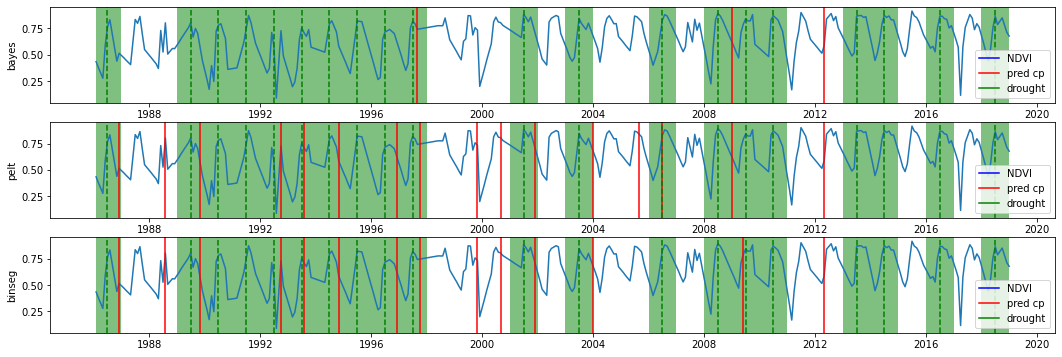

In [ ]:
true_bp = check_drought_year('aebe')
print(len(true_bp))
bm = benchmark_Models(algo_list)
true_idxs = get_drought_idxs('aebe')
df = bm.run_benchmark(harm_df['aebe'], true_idxs)
bm.plot()

19
bayes
check
pelt
binseg


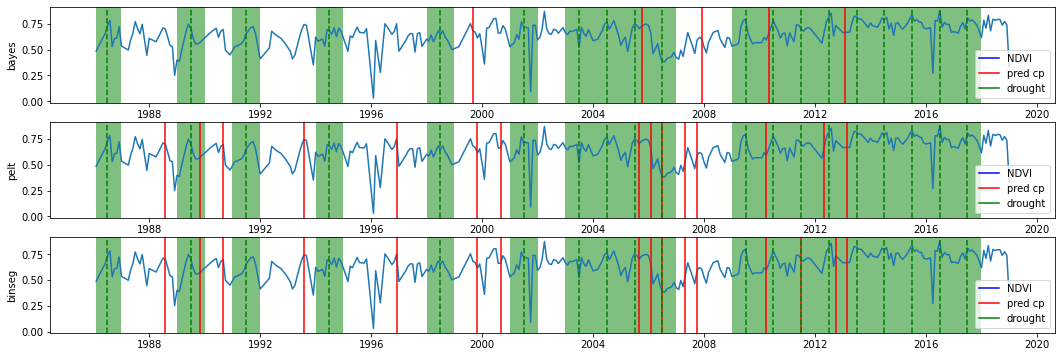

In [ ]:
#E45
true_bp = check_drought_year('E45')
print(len(true_bp))
bm = benchmark_Models(algo_list)
true_idxs = get_drought_idxs('E45')
df = bm.run_benchmark(harm_df['E45'], true_idxs)
bm.plot()


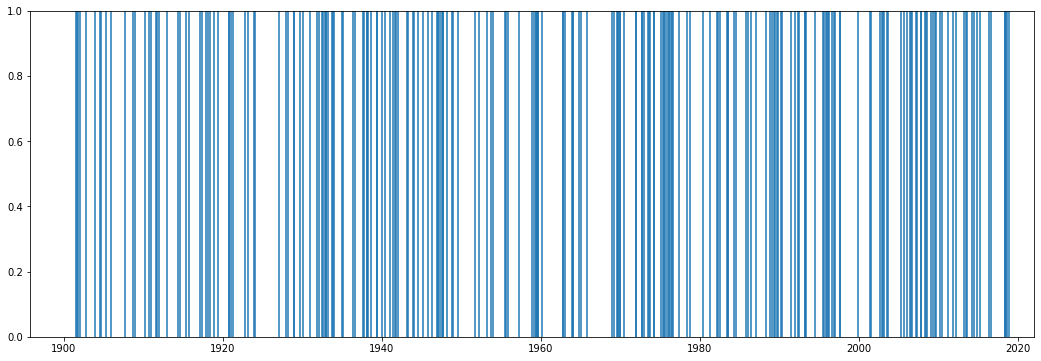

In [ ]:
fig, ax = plt.subplots()
for row in spei_df['UK53'][spei_df['aebe'] < -1].index:
  plt.axvline(row)

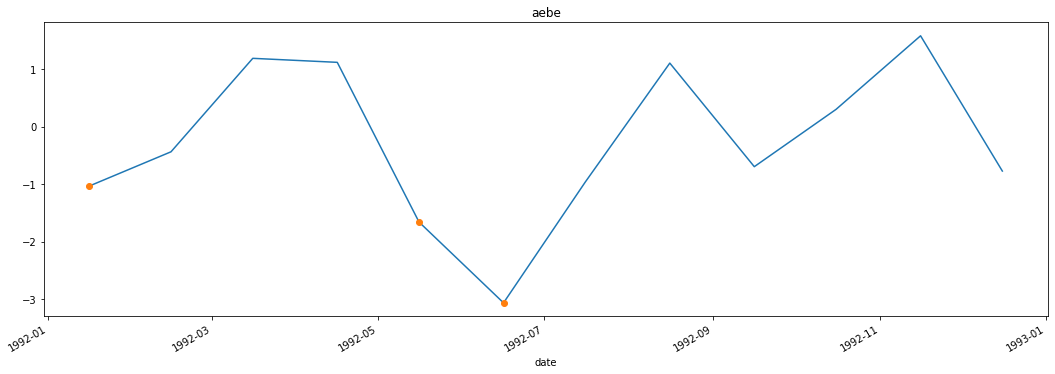

In [ ]:
def see_year_plot(spei_df, year, site):
  fig, ax = plt.subplots()
  spei_df[site].loc[year].plot(ax=ax, legend=False, ls='-')
  plt.plot(spei_df[site][spei_df[site] < -1].loc[year], 'o')#.plot.scatter(ax=ax, x='aebe', y='date', c='r', legend=False)
  ax.set_title(site)
see_year_plot(spei_df, '1992', 'aebe')

In [ ]:
mar_2_aug = spei_df[(spei_df.index.month >= 5) & (spei_df.index.month <= 8)]

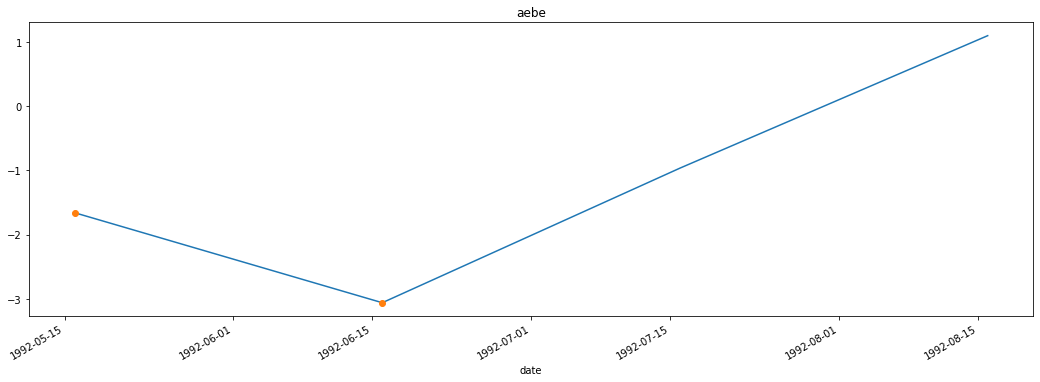

In [ ]:
see_year_plot(mar_2_aug, '1992', 'aebe')

In [ ]:
from datetime import timedelta

def get_first_bp(df, site_id, icr='month'):
  out_df = pd.DataFrame()
  pts_below = df[site_id].loc[df[site_id] < -1]


  offset = pd.DateOffset(months=1)

  bp_list = []
  bp_group = []
  for date, pt in pts_below.iteritems():
    print(date)
    if len(bp_group) == 0:
      bp_group.append(date)

    else:
      if bp_group[-1] + offset != date :
        bp_list.append(bp_group)
        bp_group = []
        bp_group = [date]
      else:
        bp_group.append(date)

  if len(bp_group) != 0:
    bp_list.append(bp_group)
  
  return bp_list

def get_drought_segments(df, site_id):
  segment = []
  seg_list = []
  for date, item in df[site_id].iteritems():
    if len(segment) == 0:
      segment.append(date)

get_drought_segments(spei_df['1992'], 'aebe')

-1.0342429876327517
-0.4391080737113953
1.184220790863037
1.1145719289779663
-1.6594680547714231
-3.0628821849823
-0.9636024236679076
1.1013959646224976
-0.6975715756416321
0.29804882407188416
1.575660228729248
-0.7736102938652039


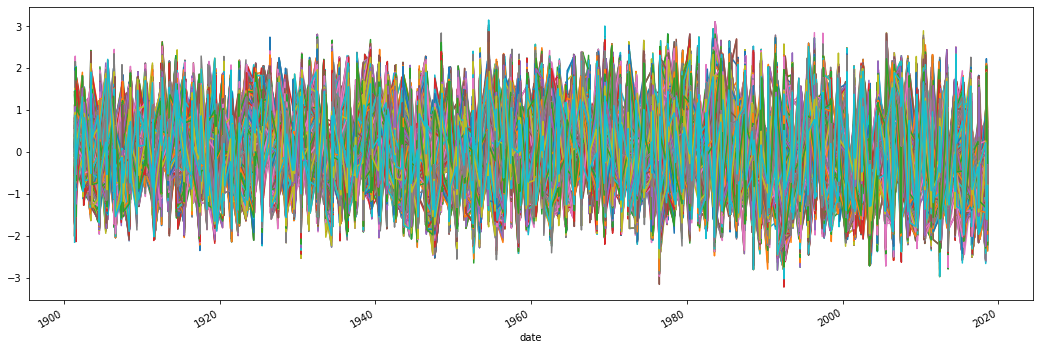

In [ ]:
mar_2_aug.plot(legend=False)

In [ ]:
def format_spei(spei_df):
  spei_df.index = spei_df['siteID']
  
  return spei_df


spei_df = format_spei(spei_df)
spei_df

,siteID,X1901.01.16,X1901.02.15,X1901.03.16,X1901.04.16,X1901.05.16,X1901.06.16,X1901.07.16,X1901.08.16,X1901.09.16,X1901.10.16,X1901.11.16,X1901.12.16,X1902.01.16,X1902.02.15,X1902.03.16,X1902.04.16,X1902.05.16,X1902.06.16,X1902.07.16,X1902.08.16,X1902.09.16,X1902.10.16,X1902.11.16,X1902.12.16,X1903.01.16,X1903.02.15,X1903.03.16,X1903.04.16,X1903.05.16,X1903.06.16,X1903.07.16,X1903.08.16,X1903.09.16,X1903.10.16,X1903.11.16,X1903.12.16,X1904.01.16,X1904.02.15,X1904.03.16,...,X2015.09.16,X2015.10.16,X2015.11.16,X2015.12.16,X2016.01.16,X2016.02.15,X2016.03.16,X2016.04.16,X2016.05.16,X2016.06.16,X2016.07.16,X2016.08.16,X2016.09.16,X2016.10.16,X2016.11.16,X2016.12.16,X2017.01.16,X2017.02.15,X2017.03.16,X2017.04.16,X2017.05.16,X2017.06.16,X2017.07.16,X2017.08.16,X2017.09.16,X2017.10.16,X2017.11.16,X2017.12.16,X2018.01.16,X2018.02.15,X2018.03.16,X2018.04.16,X2018.05.16,X2018.06.16,X2018.07.16,X2018.08.16,X2018.09.16,X2018.10.16,X2018.11.16,X2018.12.16
siteID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AHFS,AHFS,-0.513914,-0.560421,0.837071,0.910916,0.149070,0.904323,-1.003774,-0.551210,-0.757134,-0.140106,0.902670,0.556788,-0.555968,-1.612625,1.202134,-0.208508,1.687387,-0.793229,0.036282,1.022990,0.088322,-0.391501,-1.713254,-0.129967,-0.976862,0.116174,-0.838888,1.491120,-0.736430,-0.290748,-0.205038,0.945506,0.361799,1.922763,0.019448,-1.270817,-0.324222,0.848644,-0.647978,...,-0.019376,-0.505382,1.702453,-0.880461,0.147409,1.247736,-0.552270,-0.340104,-1.423433,-0.184284,-0.127745,-0.980064,-2.199658,0.095214,-0.014762,-0.298090,-0.044642,0.460410,-0.236831,0.145907,-0.240084,1.570525,1.288863,-0.112694,0.707343,1.687247,0.759457,0.087711,1.575995,-0.435798,1.182136,-0.955823,-2.583365,-1.586883,-1.790086,-1.433814,-1.987373,-1.369819,-2.015239,0.244932
OXIA15,OXIA15,-0.158616,1.044750,0.147233,-1.327423,0.500584,2.034400,-0.578384,1.085568,-0.633975,0.775671,1.064957,0.028385,-1.127443,0.842880,0.134984,-1.239464,0.990130,-0.809201,-0.700806,-0.142497,-0.510901,0.374326,0.325499,-0.123991,-1.497984,-1.226901,0.760362,1.216295,-0.013959,0.796997,0.505526,-0.594166,-1.327262,-0.437426,-0.983852,1.435010,0.926710,-0.269020,-0.492023,...,1.647445,1.013276,-0.988865,-2.198171,-0.720556,-1.403550,1.142517,-1.659355,0.562605,0.685973,-1.562711,-0.245085,1.360832,0.844205,0.220026,-1.983100,0.489977,-1.344414,-0.439768,-1.296096,0.552900,0.721557,0.766424,-1.455706,-1.036968,-1.465295,1.589148,-0.621899,-0.827174,1.790862,-0.910190,-2.150992,0.348492,2.071230,1.454063,0.462992,1.203670,-1.432327,-0.549395,-0.553378
PILI10,PILI10,-0.440997,0.664294,-0.104189,-1.142814,0.337492,1.592999,-0.409834,1.002003,-0.457628,0.573698,0.975345,-0.372932,-1.196083,0.117331,0.092469,-1.031745,0.867587,-0.655506,-0.469641,0.004935,-0.753961,0.571457,0.269609,-0.003334,-1.542777,-0.972808,0.734787,0.757810,-0.080237,0.810139,0.631351,-0.425439,-1.126181,-0.434128,-0.843149,1.364344,1.249053,-0.621822,-0.434321,...,1.618887,1.271922,-1.070586,-2.051697,-0.634268,-1.165487,1.276211,-1.958371,0.349021,0.296165,-1.435017,-0.409222,1.067535,0.691934,0.473637,-1.771029,0.584320,-1.208537,-0.217216,-1.375091,0.737467,0.854509,0.853106,-1.432123,-0.891612,-1.048023,1.299206,-0.560553,-0.790686,1.760369,-0.992178,-2.312545,0.188730,2.066182,1.629727,0.076312,1.277333,-1.305254,-0.649813,-0.507204
OSSA13,OSSA13,-0.003591,0.864000,-0.106814,-0.954341,0.401923,2.004462,-0.502735,1.065919,-0.493203,0.536156,1.015394,-0.168260,-1.092487,0.363732,0.145706,-0.924084,0.823592,-0.802425,-0.627276,0.120038,-0.415634,0.415059,0.449304,-0.003828,-1.362748,-0.838954,0.597415,0.899876,-0.029453,0.708095,0.566220,-0.497355,-1.139858,-0.453650,-0.701097,1.209306,0.954163,-0.476273,-0.396640,...,1.849220,1.430765,-0.956908,-2.188408,-0.398534,-1.260373,1.385335,-1.905364,0.582404,0.282366,-1.556137,-0.322680,1.248152,0.816606,0.214896,-1.971150,0.664780,-1.166422,-0.495436,-1.329810,0.620052,0.752352,1.096511,-1.426198,-0.890279,-1.154133,1.

**sites to lookout for**

"aebe"    "ALWB"    "CEA"     "E45"     "FSAR"    "FSGA"    "GoS"     "KHLF"    "MOT"    "NAA3"    "NKGO"    "NKZP"    "pam"     "PWTS"    "ROM_UCE" "RTAV"    "SAGB"    "SWIT345" "TRA"     "UK28"    "UK53"   